## Mount Drive


IMPORT LIBRARY & SETUP GOOGLE **DRIVE**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install biopython scikit-learn tensorflow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 48.0 MB/s eta 0:00:00


In [3]:
# Import libraries
import numpy as np
import pandas as pd
import os
from collections import Counter
import matplotlib.pyplot as plt

In [4]:
# BioPython
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq


In [5]:
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [6]:
# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

print("Semua library berhasil diimport!")

Semua library berhasil diimport!


 LOAD DATA & FILTER **SEQUENCES**

In [7]:
import os
from Bio import SeqIO
from collections import Counter

folder_path = "/content/drive/MyDrive/Bioinformatika/influenza_dataset/"
files = ["flubabi.fasta", "fluburung.fasta", "fluhuman.fasta"]  # Ditambah fluhuman.fasta

valid_sequences = []
valid_labels = []

def is_HA_sequence(record):
    """Filter hanya sequence Hemagglutinin"""
    desc = record.description.lower()
    keywords = ["ha", "hemagglutinin", "segment 4", "segment:4", "gene:ha"]
    return any(key in desc for key in keywords)

def is_corrupted(seq):
    """Cek sequence corrupted atau tidak"""
    seq = str(seq).upper()
    allowed = set("ATCG")

    # Cek karakter invalid
    bad_ratio = sum(c not in allowed for c in seq) / len(seq)
    if bad_ratio > 0.05:  # >5% karakter rusak
        return True

    # Cek panjang sequence (HA biasanya ~1700 nt)
    if len(seq) < 1000:
        return True

    return False

print("Loading and filtering sequences...")
for file_name in files:
    path = os.path.join(folder_path, file_name)
    label = file_name.replace(".fasta", "")

    if not os.path.exists(path):
        print(f"File tidak ditemukan: {path}")
        continue

    count = 0
    try:
        for record in SeqIO.parse(path, "fasta"):
            if not is_HA_sequence(record):
                continue

            if is_corrupted(record.seq):
                continue

            valid_sequences.append(str(record.seq))
            valid_labels.append(label)
            count += 1

        print(f"{file_name}: {count} sequence valid")

    except Exception as e:
        print(f"Error reading {file_name}: {e}")

print(f"\nDATA SUMMARY:")
print(f"Total sequence valid: {len(valid_sequences)}")
print(f"Distribusi label: {Counter(valid_labels)}")

# Untuk analisis lebih lanjut
if valid_sequences:
    print(f"\nContoh sequence pertama: {valid_sequences[0][:100]}...")
    print(f"Label pertama: {valid_labels[0]}")

    # Hitung panjang rata-rata
    lengths = [len(seq) for seq in valid_sequences]
    print(f"Panjang rata-rata: {sum(lengths)/len(lengths):.2f} nt")
    print(f"Panjang min-max: {min(lengths)} - {max(lengths)} nt")

Loading and filtering sequences...
flubabi.fasta: 50 sequence valid
fluburung.fasta: 50 sequence valid
fluhuman.fasta: 50 sequence valid

DATA SUMMARY:
Total sequence valid: 150
Distribusi label: Counter({'flubabi': 50, 'fluburung': 50, 'fluhuman': 50})

Contoh sequence pertama: ATGAAAGTAAAACTAATGGTTCTGTTATGTACATTTACAGCTACGTATGCAGACACAATATGCGTAGGCTACCATGCCAACAACTCAACGGACACTGTTG...
Label pertama: flubabi
Panjang rata-rata: 1732.55 nt
Panjang min-max: 1695 - 1778 nt


In [8]:
# Cek contoh sequence
if len(valid_sequences) > 0:
    print(f"\nContoh sequence pertama:")
    print(f"Panjang: {len(valid_sequences[0])} bp")
    print(f"Label: {valid_labels[0]}")
    print(f"50 bp pertama: {valid_sequences[0][:50]}...")


Contoh sequence pertama:
Panjang: 1698 bp
Label: flubabi
50 bp pertama: ATGAAAGTAAAACTAATGGTTCTGTTATGTACATTTACAGCTACGTATGC...


PREPARE DATAFRAME & GENERATE K-**MERS**

In [9]:
def get_kmers(seq, k=6):
    """Generate k-mers dari sequence"""
    return [seq[i:i+k] for i in range(len(seq) - k + 1)]

In [10]:
# Buat dataframe
print("\nMembuat DataFrame...")
data = []
for seq_str, label_str in zip(valid_sequences, valid_labels):
    if label_str == 'fluburung':
        data.append({"sequence": seq_str, "label": 1})  # fluburung = 1
    elif label_str == 'flubabi':
        data.append({"sequence": seq_str, "label": 0})  # flubabi = 0
    elif label_str == 'fluhuman':  # TAMBAHAN UNTUK DATASET KETIGA
        data.append({"sequence": seq_str, "label": 2})  # fluhuman = 2

df = pd.DataFrame(data)


Membuat DataFrame...


In [11]:
# Generate k-mers
print("Generating k-mers (k=6)...")
df["kmers"] = df["sequence"].apply(lambda x: " ".join(get_kmers(x, k=6)))

print(f"DataFrame shape: {df.shape}")
print(f"Class distribution: {df['label'].value_counts()}")

print("\nSample data:")
print(df.head())


Generating k-mers (k=6)...
DataFrame shape: (150, 3)
Class distribution: label
0    50
1    50
2    50
Name: count, dtype: int64

Sample data:
                                            sequence  label  \
0  ATGAAAGTAAAACTAATGGTTCTGTTATGTACATTTACAGCTACGT...      0   
1  ATGAAGGCAATACTAGTAGTCCTGCTATATACATTTACAAAAGCAA...      0   
2  ATGAAAGTAAAACTAATGGTTCTGTTATGTACATTTACAGCTACGT...      0   
3  ATGAGAGTAAAACTACTAATCCTAATATGCACATTTACAGCTACAT...      0   
4  ATGAAGGCAATGCTAGTAGTCCTGCTATATACATTTTCAAAAGCAA...      0   

                                               kmers  
0  ATGAAA TGAAAG GAAAGT AAAGTA AAGTAA AGTAAA GTAA...  
1  ATGAAG TGAAGG GAAGGC AAGGCA AGGCAA GGCAAT GCAA...  
2  ATGAAA TGAAAG GAAAGT AAAGTA AAGTAA AGTAAA GTAA...  
3  ATGAGA TGAGAG GAGAGT AGAGTA GAGTAA AGTAAA GTAA...  
4  ATGAAG TGAAGG GAAGGC AAGGCA AGGCAA GGCAAT GCAA...  


In [12]:
# Cek statistik k-mers
kmers_per_seq = df["kmers"].apply(lambda x: len(x.split()))
print(f"\nStatistik k-mers per sequence:")
print(f"Rata-rata: {kmers_per_seq.mean():.1f}")
print(f"Min: {kmers_per_seq.min()}")
print(f"Max: {kmers_per_seq.max()}")


Statistik k-mers per sequence:
Rata-rata: 1727.6
Min: 1690
Max: 1773


**DATA SPLIT (80:20)**

In [14]:
print("\n" + "="*60)
print("SPLITTING DATA (Menghindari Data Leakage)")
print("="*60)

# SPLIT DULU sebelum transformasi apapun!
X_text = df["kmers"]  # Masih dalam bentuk text
y = df["label"]

# Cek distribusi kelas sebelum split
print(f"Distribusi kelas sebelum split: {dict(sorted(Counter(y).items()))}")

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class distribution untuk 3 kelas
)

print(f"\nTraining set: {len(X_train_text)} sequences")
print(f"Test set: {len(X_test_text)} sequences")
print(f"Class distribution in training: {dict(sorted(Counter(y_train).items()))}")
print(f"Class distribution in test: {dict(sorted(Counter(y_test).items()))}")

# VERIFIKASI: Pastikan semua kelas ada di training dan test
train_classes = set(y_train)
test_classes = set(y_test)
all_classes = set(y.unique())

print(f"\nVerifikasi:")
print(f"Semua kelas: {sorted(all_classes)}")
print(f"Kelas di training: {sorted(train_classes)}")
print(f"Kelas di test: {sorted(test_classes)}")

if train_classes != all_classes:
    print("Peringatan: Tidak semua kelas ada di training set!")
if test_classes != all_classes:
    print("Peringatan: Tidak semua kelas ada di test set!")

# Simpan original sequences untuk referensi
train_sequences = df.loc[X_train_text.index, "sequence"]
test_sequences = df.loc[X_test_text.index, "sequence"]

print(f"\nData splitting selesai!")


SPLITTING DATA (Menghindari Data Leakage)
Distribusi kelas sebelum split: {0: 50, 1: 50, 2: 50}

Training set: 120 sequences
Test set: 30 sequences
Class distribution in training: {0: 40, 1: 40, 2: 40}
Class distribution in test: {0: 10, 1: 10, 2: 10}

Verifikasi:
Semua kelas: [np.int64(0), np.int64(1), np.int64(2)]
Kelas di training: [0, 1, 2]
Kelas di test: [0, 1, 2]

Data splitting selesai!


**TF-IDF TRANSFORMATION**

In [15]:
print("\n" + "="*50)
print("TF-IDF TRANSFORMATION")
print("="*50)

# TF-IDF HANYA pada training data
vectorizer = TfidfVectorizer(
    max_features=3000,  # Batasi features untuk hindari overfit
    min_df=2,           # Ignore terms that appear in less than 2 documents
    max_df=0.8          # Ignore terms that appear in more than 80% of documents
)

print("Fitting TF-IDF pada training data...")
X_train_tfidf = vectorizer.fit_transform(X_train_text)  # Hanya learn dari train
X_test_tfidf = vectorizer.transform(X_test_text)        # Transform test pakai vocabulary train

print(f"TF-IDF Training shape: {X_train_tfidf.shape}")
print(f"TF-IDF Test shape: {X_test_tfidf.shape}")
print(f"Jumlah feature (k-mers unik): {len(vectorizer.get_feature_names_out())}")

# Cek beberapa feature (k-mers) yang dihasilkan
feature_names = vectorizer.get_feature_names_out()
print(f"\nSample features (k-mers): {feature_names[:10]}")



TF-IDF TRANSFORMATION
Fitting TF-IDF pada training data...
TF-IDF Training shape: (120, 3000)
TF-IDF Test shape: (30, 3000)
Jumlah feature (k-mers unik): 3000

Sample features (k-mers): ['aaaaat' 'aaaacc' 'aaaacg' 'aaaact' 'aaaagc' 'aaaagt' 'aaaatc' 'aaaatt'
 'aaacat' 'aaaccc']


**VISUALISASI PCA**


VISUALISASI PCA
Fitting PCA pada training data...
Variance explained: PC1=0.345, PC2=0.190
Total variance explained: 0.536


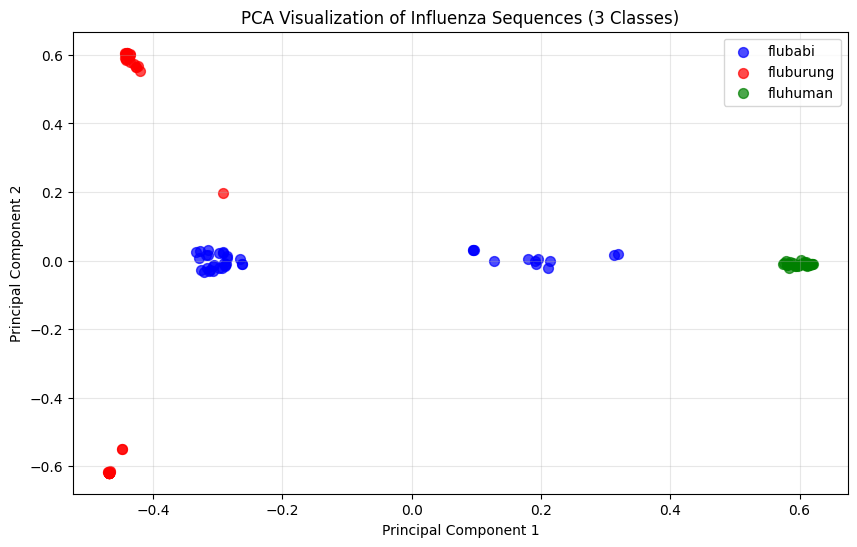

PCA visualization selesai!


In [16]:
print("\n" + "="*40)
print("VISUALISASI PCA")
print("="*40)

# PCA untuk visualisasi (gunakan data training saja untuk fit)
pca = PCA(n_components=2)
print("Fitting PCA pada training data...")
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())

# Hitung variance explained
variance_explained = pca.explained_variance_ratio_
print(f"Variance explained: PC1={variance_explained[0]:.3f}, PC2={variance_explained[1]:.3f}")
print(f"Total variance explained: {sum(variance_explained):.3f}")

# Buat DataFrame untuk PCA results
df_pca = pd.DataFrame(X_train_pca, columns=['PCA1', 'PCA2'])
df_pca['label'] = y_train.values
df_pca['label_name'] = df_pca['label'].map({0: 'flubabi', 1: 'fluburung', 2: 'fluhuman'})  # DIPERBAIKI

# Visualisasi
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green']  # DIPERBAIKI: tambah warna untuk kelas ke-3
label_names = {0: 'flubabi', 1: 'fluburung', 2: 'fluhuman'}  # DIPERBAIKI

for label_value in sorted(df_pca['label'].unique()):  # DIPERBAIKI: iterasi semua kelas
    mask = df_pca['label'] == label_value
    plt.scatter(df_pca.loc[mask, 'PCA1'], df_pca.loc[mask, 'PCA2'],
               c=colors[label_value],
               label=label_names[label_value],  # DIPERBAIKI
               alpha=0.7, s=50)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Influenza Sequences (3 Classes)')  # DIPERBAIKI: update judul
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("PCA visualization selesai!")

# **RANDOM FOREST CLASSIFIER**

In [17]:
print("\n" + "="*50)
print("TRAINING RANDOM FOREST")
print("="*50)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,        # Batasi depth untuk hindari overfit
    min_samples_split=5, # Minimum samples untuk split
    min_samples_leaf=2,  # Minimum samples di leaf
    random_state=42
)

print("Training Random Forest...")
rf_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_rf_train = rf_model.predict(X_train_tfidf)
y_pred_rf_test = rf_model.predict(X_test_tfidf)

print("RANDOM FOREST RESULTS")
print(f"Training Accuracy: {accuracy_score(y_train, y_pred_rf_train):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_rf_test):.4f}")

print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_rf_test))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf_test)
print(f"\nConfusion Matrix:")
print(cm)

# Feature Importance
feature_importance = pd.DataFrame({
    'kmer': vectorizer.get_feature_names_out(),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 most important k-mers:")
print(feature_importance.head(10))

# Cek overfitting
train_test_gap = accuracy_score(y_train, y_pred_rf_train) - accuracy_score(y_test, y_pred_rf_test)
if train_test_gap > 0.2:
    print(f"Warning: Kemungkinan overfitting (selisih train-test: {train_test_gap:.3f})")
else:
    print(f"Model cukup stabil (selisih train-test: {train_test_gap:.3f})")


TRAINING RANDOM FOREST
Training Random Forest...
RANDOM FOREST RESULTS
Training Accuracy: 1.0000
Test Accuracy: 0.9333

Test Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       1.00      0.80      0.89        10
           2       1.00      1.00      1.00        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30


Confusion Matrix:
[[10  0  0]
 [ 2  8  0]
 [ 0  0 10]]

Top 10 most important k-mers:
        kmer  importance
373   acttac    0.024063
881   cagaac    0.021016
309   acgcaa    0.018567
1871  ggcaac    0.016658
2839  ttattc    0.015540
761   attcga    0.014921
2504  tcctct    0.014888
1344  ctctgg    0.014503
2078  gtcaat    0.014427
511   aggcta    0.011513
Model cukup stabil (selisih train-test: 0.067)


### **SUPPORT VECTOR MACHINE (SVM) CLASSIFIER**

In [18]:
print("\n" + "="*50)
print("TRAINING SUPPORT VECTOR MACHINE")
print("="*50)

from sklearn.svm import SVC

svm_model = SVC(
    kernel='linear', # Linear kernel often works well for high-dimensional text data
    random_state=42,
    probability=True # Enable probability estimates for consistency with other models
)

print("Training SVM...")
svm_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_svm_train = svm_model.predict(X_train_tfidf)
y_pred_svm_test = svm_model.predict(X_test_tfidf)

print("SVM RESULTS")
print(f"Training Accuracy: {accuracy_score(y_train, y_pred_svm_train):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_svm_test):.4f}")

print("\nTest Classification Report (SVM):")
print(classification_report(y_test, y_pred_svm_test))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm_test)
print(f"\nConfusion Matrix (SVM):")
print(cm_svm)

# Cek overfitting
train_test_gap_svm = accuracy_score(y_train, y_pred_svm_train) - accuracy_score(y_test, y_pred_svm_test)
if train_test_gap_svm > 0.2:
    print(f"Warning: Kemungkinan overfitting (selisih train-test: {train_test_gap_svm:.3f})")
else:
    print(f"Model cukup stabil (selisih train-test: {train_test_gap_svm:.3f})")


TRAINING SUPPORT VECTOR MACHINE
Training SVM...
SVM RESULTS
Training Accuracy: 1.0000
Test Accuracy: 1.0000

Test Classification Report (SVM):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Confusion Matrix (SVM):
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]
Model cukup stabil (selisih train-test: 0.000)


### **LOGISTIC REGRESSION CLASSIFIER**

In [19]:
print("\n" + "="*50)
print("TRAINING LOGISTIC REGRESSION")
print("="*50)

from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(
    random_state=42,
    max_iter=1000 # Increase max_iter for convergence
)

print("Training Logistic Regression...")
logreg_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_logreg_train = logreg_model.predict(X_train_tfidf)
y_pred_logreg_test = logreg_model.predict(X_test_tfidf)

print("LOGISTIC REGRESSION RESULTS")
print(f"Training Accuracy: {accuracy_score(y_train, y_pred_logreg_train):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_logreg_test):.4f}")

print("\nTest Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_logreg_test))

# Confusion Matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg_test)
print(f"\nConfusion Matrix (Logistic Regression):")
print(cm_logreg)

# Cek overfitting
train_test_gap_logreg = accuracy_score(y_train, y_pred_logreg_train) - accuracy_score(y_test, y_pred_logreg_test)
if train_test_gap_logreg > 0.2:
    print(f"Warning: Kemungkinan overfitting (selisih train-test: {train_test_gap_logreg:.3f})")
else:
    print(f"Model cukup stabil (selisih train-test: {train_test_gap_logreg:.3f})")


TRAINING LOGISTIC REGRESSION
Training Logistic Regression...
LOGISTIC REGRESSION RESULTS
Training Accuracy: 1.0000
Test Accuracy: 1.0000

Test Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Confusion Matrix (Logistic Regression):
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]
Model cukup stabil (selisih train-test: 0.000)


**PREPARE DATA UNTUK CNN**

In [20]:
# ====================
# SEGMENT 8: PREPARE DATA CNN
# ====================

print("\n" + "="*50)
print("PREPARE DATA UNTUK CNN")
print("="*50)

# Convert sparse matrix to dense array untuk CNN
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

print(f"Original shape - Training: {X_train_dense.shape}, Test: {X_test_dense.shape}")

# Reshape untuk CNN: (samples, timesteps, features)
X_train_cnn = X_train_dense.reshape(X_train_dense.shape[0], X_train_dense.shape[1], 1)
X_test_cnn = X_test_dense.reshape(X_test_dense.shape[0], X_test_dense.shape[1], 1)

print(f"CNN shape - Training: {X_train_cnn.shape}, Test: {X_test_cnn.shape}")
print(f"Input shape untuk CNN: {X_train_cnn.shape[1:]}")

print("Data preparation untuk CNN selesai!")


PREPARE DATA UNTUK CNN
Original shape - Training: (120, 3000), Test: (30, 3000)
CNN shape - Training: (120, 3000, 1), Test: (30, 3000, 1)
Input shape untuk CNN: (3000, 1)
Data preparation untuk CNN selesai!


**BUILD & TRAIN CNN MODEL**

In [30]:
# ====================
# SEGMENT 9: BUILD & TRAIN CNN
# ====================

print("\n" + "="*50)
print("BUILDING CNN MODEL (3 CLASSES)")
print("="*50)

# 1. ONE-HOT ENCODING untuk 3 kelas
from tensorflow.keras.utils import to_categorical

num_classes = 3  # TAMBAHAN: karena ada 3 kelas
y_train_cnn = to_categorical(y_train, num_classes=num_classes)
y_test_cnn = to_categorical(y_test, num_classes=num_classes)

print(f"One-hot encoded labels - Training shape: {y_train_cnn.shape}")
print(f"One-hot encoded labels - Test shape: {y_test_cnn.shape}")

# 2. Build CNN model untuk MULTI-CLASS
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    # PERUBAHAN PENTING: Output layer untuk 3 kelas
    Dense(num_classes, activation='softmax')  # softmax untuk multi-class
])

# 3. Compile model untuk MULTI-CLASS
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # PERUBAHAN: categorical crossentropy
    metrics=['accuracy']
)

print("CNN Model architecture (3 classes):")
cnn_model.summary()

# 4. Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("\n🚀 Training CNN model (3 classes)...")
history = cnn_model.fit(
    X_train_cnn, y_train_cnn,  # PERUBAHAN: gunakan y_train_cnn (one-hot)
    epochs=20,
    batch_size=8,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print(f"Training selesai pada epoch {len(history.history['loss'])}")

# 5. Evaluasi model (nanti perlu diubah juga)
print("\nEvaluating CNN model...")
test_loss, test_acc = cnn_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions untuk classification report
y_pred_cnn_probs = cnn_model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test_cnn, axis=1)  # Convert one-hot back to labels

print("\nCNN Classification Report (3 classes):")
print(classification_report(y_true, y_pred_cnn))


BUILDING CNN MODEL (3 CLASSES)
One-hot encoded labels - Training shape: (120, 3)
One-hot encoded labels - Test shape: (30, 3)
CNN Model architecture (3 classes):


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 2998, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 1499, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 1499, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 1497, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 748, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 748, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 47872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │     3,063,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,070,659 (11.71 MB)

 Trainable params: 3,070,531 (11.71 MB)

 Non-trainable params: 128 (512.00 B)


🚀 Training CNN model (3 classes)...
Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 264ms/step - accuracy: 0.7805 - loss: 1.6966 - val_accuracy: 0.3333 - val_loss: 2.0946
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.9745 - loss: 1.1329 - val_accuracy: 0.3333 - val_loss: 1.9672
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.9894 - loss: 0.9921 - val_accuracy: 0.3333 - val_loss: 1.6823
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 1.0000 - loss: 0.7989 - val_accuracy: 0.5417 - val_loss: 1.4499
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9694 - loss: 0.7221 - val_accuracy: 0.6667 - val_loss: 1.3351
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.5971 - val_accuracy: 0.7500 - val_loss: 1.2265
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 0.5474 - val_accuracy: 1.0000 - val_loss: 1.1004
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.00

**EVALUATE CNN & COMPARE MODELS**


EVALUATING CNN MODEL (3 CLASSES)
=== CNN RESULTS (3 CLASSES) ===
Training Accuracy: 1.0000
Test Accuracy: 1.0000
Training Loss: 0.5897
Test Loss: 0.6211
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

Test Classification Report (CNN - 3 Classes):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Confusion Matrix (CNN):
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]

TRAINING HISTORY VISUALIZATION


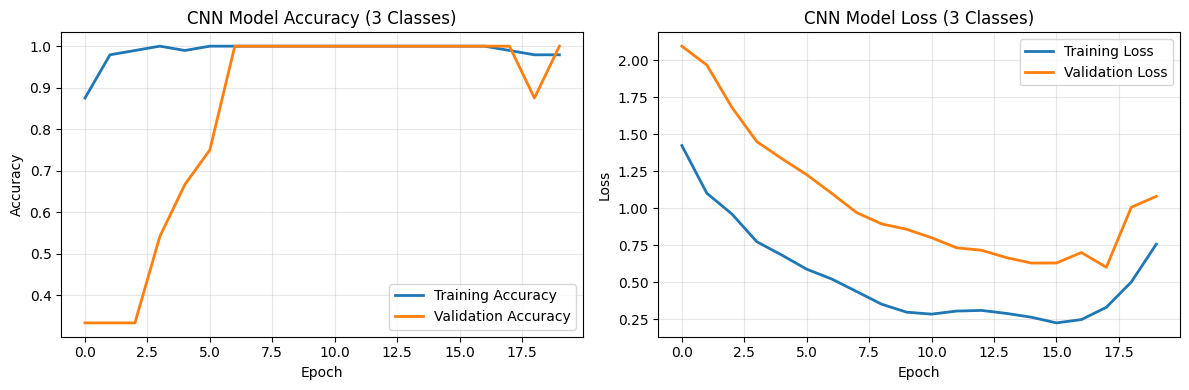


FINAL MODEL COMPARISON (3 CLASSES)
                 Model  Train Accuracy  Test Accuracy  Overfitting Gap
0        Random Forest             1.0       0.933333         0.066667
1                  CNN             1.0       1.000000         0.000000
2                  SVM             1.0       1.000000         0.000000
3  Logistic Regression             1.0       1.000000         0.000000

CONCLUSION (3 CLASSES)
MODEL TERBAIK: CNN (Test Accuracy: 1.0000)

ANALISIS OVERFITTING:
• Random Forest: ✅ STABIL (gap: 0.067)
• CNN: ✅ STABIL (gap: 0.000)
• SVM: ✅ STABIL (gap: 0.000)
• Logistic Regression: ✅ STABIL (gap: 0.000)

📊 DATA DISTRIBUTION:
Total sequences: 150
Kelas 0 (babi): 50 sequences
Kelas 1 (burung): 50 sequences
Kelas 2 (manusia): 50 sequences
Feature dimensions: 3000 k-mers
Training set: 120 sequences
Test set: 30 sequences

PROSES SELESAI! (3 CLASSES CLASSIFICATION)


In [32]:
# ====================
# SEGMENT 10: EVALUATION & COMPARISON
# ====================

print("\n" + "="*50)
print("EVALUATING CNN MODEL (3 CLASSES)")
print("="*50)

# CNN Evaluation - PERUBAHAN: gunakan one-hot encoded labels
train_loss, train_acc = cnn_model.evaluate(X_train_cnn, y_train_cnn, verbose=0)
test_loss, test_acc = cnn_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)

print(f"=== CNN RESULTS (3 CLASSES) ===")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Training Loss: {train_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predictions untuk CNN - PERUBAHAN: untuk multi-class
y_pred_cnn_probs = cnn_model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn_probs, axis=1)  # Ambil kelas dengan probabilitas tertinggi
y_true_cnn = np.argmax(y_test_cnn, axis=1)  # Konversi dari one-hot ke label

print("\nTest Classification Report (CNN - 3 Classes):")
print(classification_report(y_true_cnn, y_pred_cnn))

# Confusion Matrix for CNN
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
print(f"\nConfusion Matrix (CNN):")
print(cm_cnn)

# ====================
# VISUALISASI HASIL
# ====================

print("\n" + "="*50)
print("TRAINING HISTORY VISUALIZATION")
print("="*50)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('CNN Model Accuracy (3 Classes)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('CNN Model Loss (3 Classes)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ====================
# MODEL COMPARISON
# ====================

print("\n" + "="*50)
print("FINAL MODEL COMPARISON (3 CLASSES)")
print("="*50)

# Untuk model tradisional (RF, SVM, Logistic) tetap pakai y_test biasa
# Untuk CNN pakai y_true_cnn dan y_pred_cnn

models_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'CNN', 'SVM', 'Logistic Regression'],
    'Train Accuracy': [
        accuracy_score(y_train, y_pred_rf_train),
        train_acc,
        accuracy_score(y_train, y_pred_svm_train),
        accuracy_score(y_train, y_pred_logreg_train)
    ],
    'Test Accuracy': [
        accuracy_score(y_test, y_pred_rf_test),
        test_acc,
        accuracy_score(y_test, y_pred_svm_test),
        accuracy_score(y_test, y_pred_logreg_test)
    ],
    'Overfitting Gap': [
        accuracy_score(y_train, y_pred_rf_train) - accuracy_score(y_test, y_pred_rf_test),
        train_acc - test_acc,
        accuracy_score(y_train, y_pred_svm_train) - accuracy_score(y_test, y_pred_svm_test),
        accuracy_score(y_train, y_pred_logreg_train) - accuracy_score(y_test, y_pred_logreg_test)
    ]
})

print(models_comparison)

# ====================
# KESIMPULAN
# ====================

print("\n" + "=" * 30)
print("CONCLUSION (3 CLASSES)")
print("=" * 30)

best_model_idx = models_comparison['Test Accuracy'].idxmax()
best_model = models_comparison.loc[best_model_idx, 'Model']
best_accuracy = models_comparison.loc[best_model_idx, 'Test Accuracy']

print(f"MODEL TERBAIK: {best_model} (Test Accuracy: {best_accuracy:.4f})")

print("\nANALISIS OVERFITTING:")
for i, row in models_comparison.iterrows():
    status = "OVERFITTING" if row['Overfitting Gap'] > 0.2 else "✅ STABIL"
    print(f"• {row['Model']}: {status} (gap: {row['Overfitting Gap']:.3f})")

# Hitung distribusi kelas
print(f"\n📊 DATA DISTRIBUTION:")
print(f"Total sequences: {len(df)}")
print(f"Kelas 0 (babi): {sum(df['label'] == 0)} sequences")
print(f"Kelas 1 (burung): {sum(df['label'] == 1)} sequences")
print(f"Kelas 2 (manusia): {sum(df['label'] == 2)} sequences")
print(f"Feature dimensions: {X_train_tfidf.shape[1]} k-mers")
print(f"Training set: {len(X_train_text)} sequences")
print(f"Test set: {len(X_test_text)} sequences")

print("\nPROSES SELESAI! (3 CLASSES CLASSIFICATION)")

# Confusion Matrix

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, labels, title):
    """Generates and displays a heatmap of the confusion matrix."""
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels
    )
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

print("Confusion Matrix plotting function 'plot_confusion_matrix' defined.")

Confusion Matrix plotting function 'plot_confusion_matrix' defined.


**Reasoning**:
Now that the `plot_confusion_matrix` function is defined, I will use it to visualize the confusion matrices for the Random Forest, SVM, and Logistic Regression models to compare their performance.




CONFUSION MATRIX VISUALIZATION (3 CLASSES)

1. Random Forest Confusion Matrix:
[[10  0  0]
 [ 2  8  0]
 [ 0  0 10]]


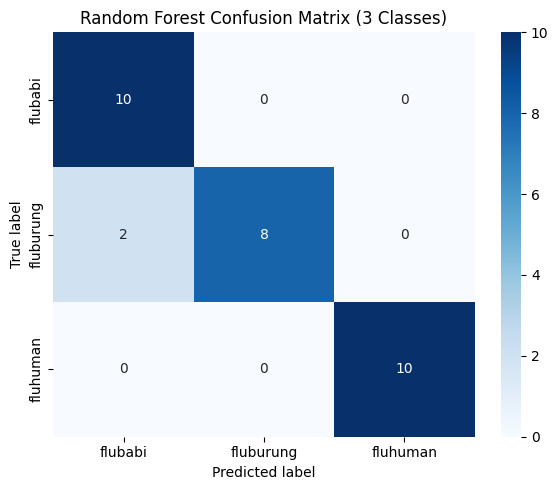


2. SVM Confusion Matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


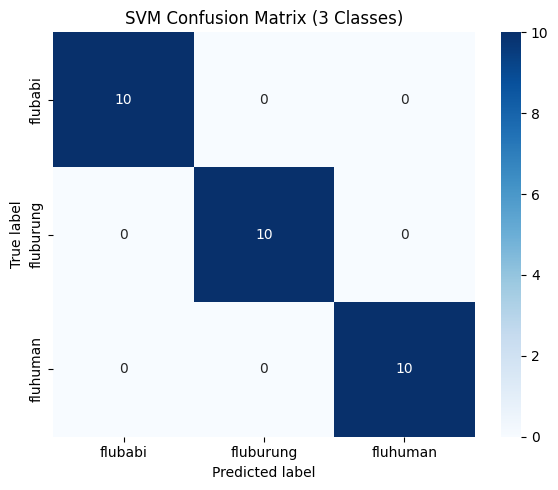


3. Logistic Regression Confusion Matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


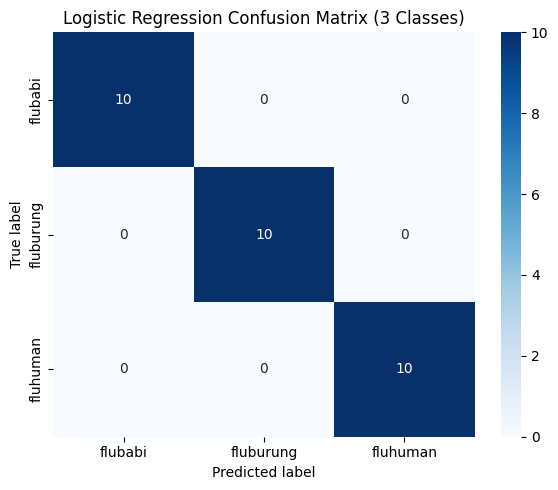


4. CNN Confusion Matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]


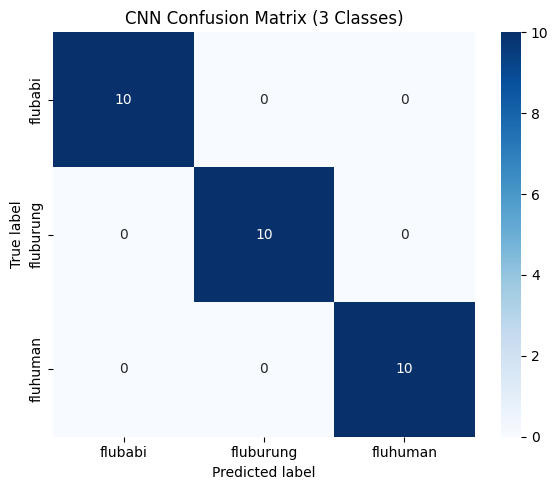


✅ Confusion matrix visualizations complete for 3 classes.


In [35]:
print("\n" + "="*50)
print("CONFUSION MATRIX VISUALIZATION (3 CLASSES)")
print("="*50)

# PERUBAHAN: Update labels untuk 3 kelas
labels = ['flubabi', 'fluburung', 'fluhuman']

# 1. Random Forest Confusion Matrix
print("\n1. Random Forest Confusion Matrix:")
print(cm)  # cm dari Random Forest sebelumnya
plot_confusion_matrix(cm, labels, 'Random Forest Confusion Matrix (3 Classes)')

# 2. SVM Confusion Matrix
print("\n2. SVM Confusion Matrix:")
print(cm_svm)  # cm_svm dari SVM sebelumnya
plot_confusion_matrix(cm_svm, labels, 'SVM Confusion Matrix (3 Classes)')

# 3. Logistic Regression Confusion Matrix
print("\n3. Logistic Regression Confusion Matrix:")
print(cm_logreg)  # cm_logreg dari Logistic Regression sebelumnya
plot_confusion_matrix(cm_logreg, labels, 'Logistic Regression Confusion Matrix (3 Classes)')

# 4. CNN Confusion Matrix
print("\n4. CNN Confusion Matrix:")
print(cm_cnn)  # cm_cnn dari CNN (yang sudah diperbaiki)
plot_confusion_matrix(cm_cnn, labels, 'CNN Confusion Matrix (3 Classes)')

print("\n✅ Confusion matrix visualizations complete for 3 classes.")

***GRAFIK***

DENDRO


HIERARCHICAL CLUSTERING DENDROGRAM
Calculating distance matrix...
Performing hierarchical clustering...


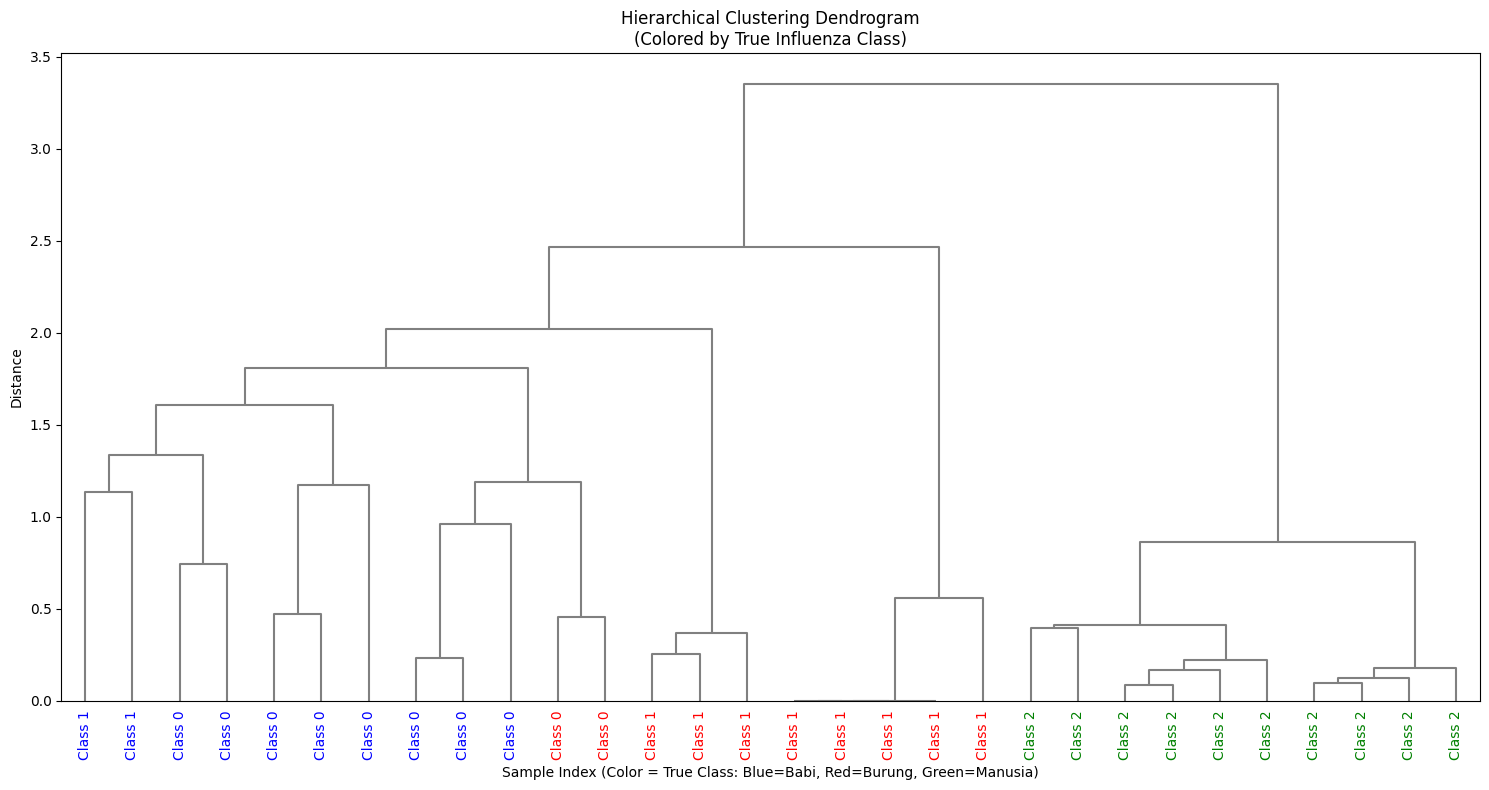

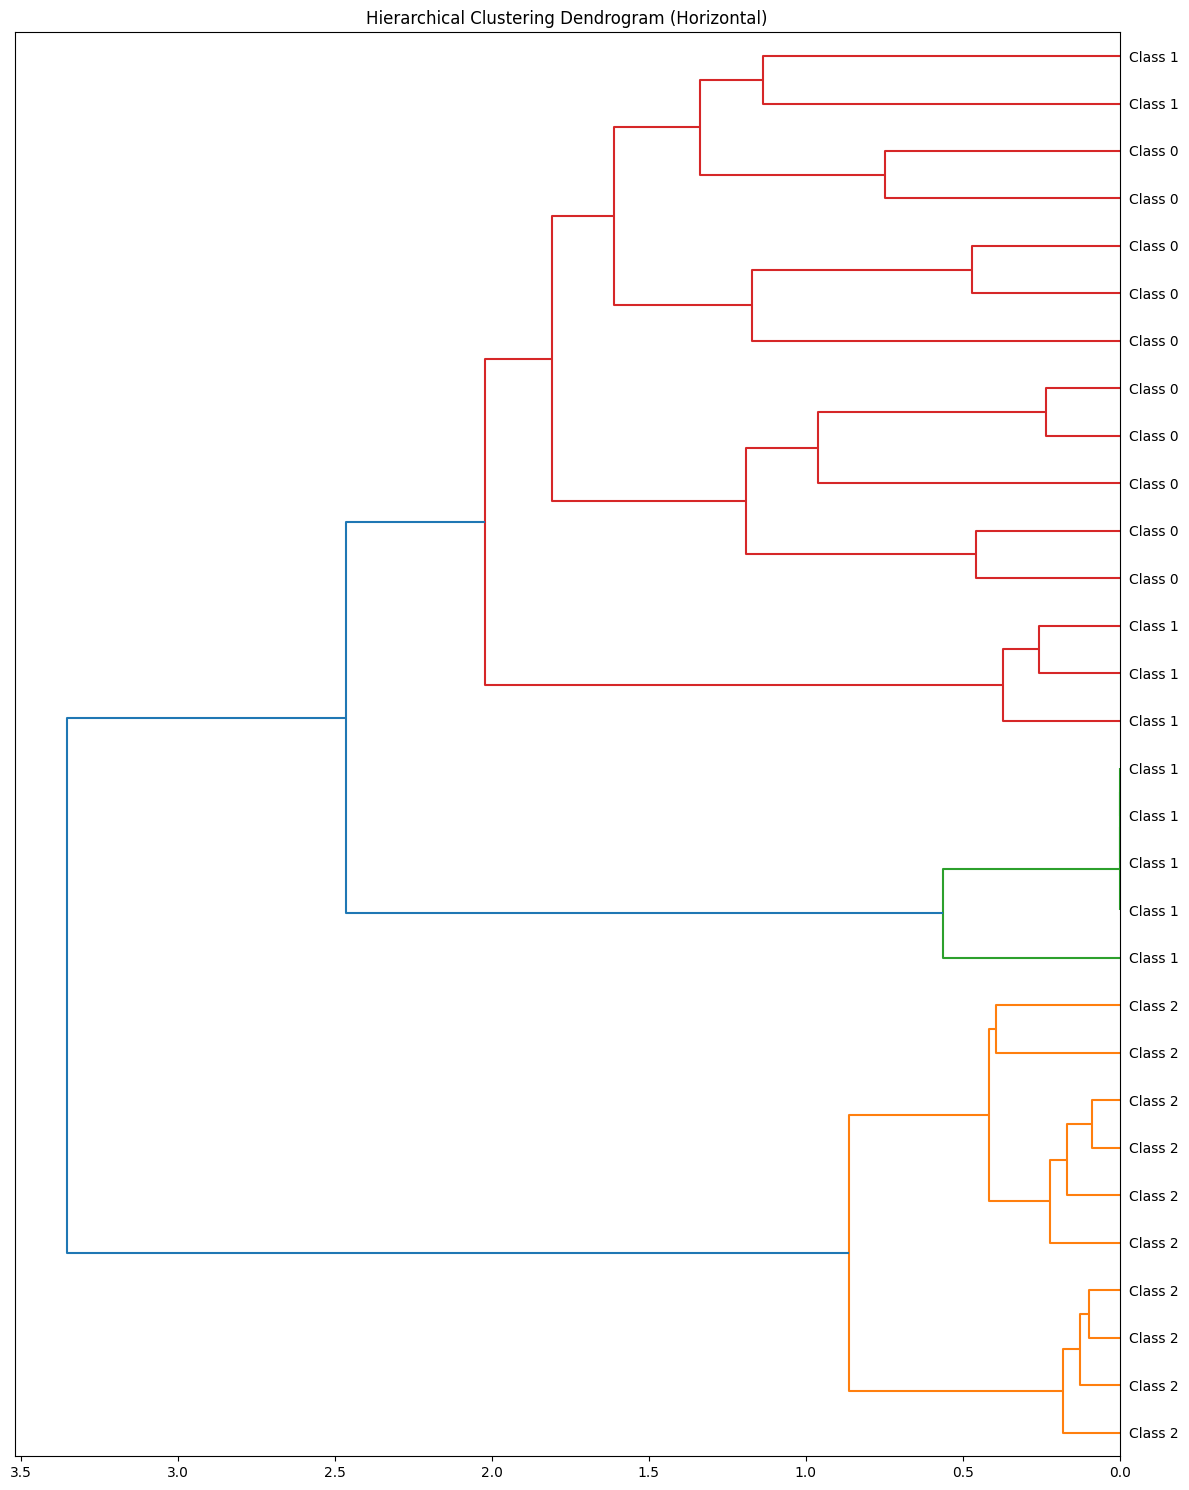

Dendrograms generated.

Interpretasi Dendrogram:
Tinggi vertikal = jarak/dissimilarity antar cluster
Warna label: Blue = Babi, Red = Burung, Green = Manusia
Cluster yang rendah = sequence mirip
Cluster yang tinggi = sequence berbeda


In [41]:
print("\n" + "="*50)
print("HIERARCHICAL CLUSTERING DENDROGRAM")
print("="*50)

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Ambil subset data untuk dendrogram (maks 50 sample per kelas agar tidak terlalu padat)
sample_indices = []
for class_label in [0, 1, 2]:
    class_indices = np.where(y_test == class_label)[0]
    sample_size = min(20, len(class_indices))  # 20 sample per kelas
    sample_indices.extend(np.random.choice(class_indices, sample_size, replace=False))

X_sample = X_test_dense[sample_indices]
y_sample = y_test.iloc[sample_indices] if hasattr(y_test, 'iloc') else y_test[sample_indices]

# Hitung distance matrix
print("Calculating distance matrix...")
distance_matrix = pdist(X_sample, metric='euclidean')

# Hierarchical clustering
print("Performing hierarchical clustering...")
linked = linkage(distance_matrix, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 8))

# Buat dendrogram dengan warna berdasarkan kelas
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette

# Mapping warna untuk kelas
label_colors = {0: 'blue', 1: 'red', 2: 'green'}

# Buat color list untuk leaves
leaf_colors = [label_colors[label] for label in y_sample]

# Plot dendrogram
dendro = dendrogram(
    linked,
    orientation='top',
    labels=[f'Class {label}' for label in y_sample.values],
    distance_sort='descending',
    show_leaf_counts=True,
    leaf_rotation=90,
    leaf_font_size=10,
    # Tambahkan warna berdasarkan true label
    link_color_func=lambda k: 'gray'  # Warna link tetap gray
)

# Tambahkan titik berwarna berdasarkan kelas di leaf labels
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl, color in zip(xlbls, leaf_colors):
    lbl.set_color(color)

plt.title('Hierarchical Clustering Dendrogram\n(Colored by True Influenza Class)')
plt.xlabel('Sample Index (Color = True Class: Blue=Babi, Red=Burung, Green=Manusia)')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Juga tampilkan dalam bentuk horizontal
plt.figure(figsize=(12, 15))
dendrogram(
    linked,
    orientation='left',
    labels=[f'Class {label}' for label in y_sample.values],
    leaf_font_size=10,
    # leaf_label_func=lambda x: f"Class {y_sample.iloc[x] if hasattr(y_sample, 'iloc') else y_sample[x]}",
)
plt.title('Hierarchical Clustering Dendrogram (Horizontal)')
plt.tight_layout()
plt.show()

print("Dendrograms generated.")
print("\nInterpretasi Dendrogram:")
print("Tinggi vertikal = jarak/dissimilarity antar cluster")
print("Warna label: Blue = Babi, Red = Burung, Green = Manusia")
print("Cluster yang rendah = sequence mirip")
print("Cluster yang tinggi = sequence berbeda")

ROC



ROC CURVES (3 CLASSES - One-vs-Rest)

Generating ROC for CNN...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


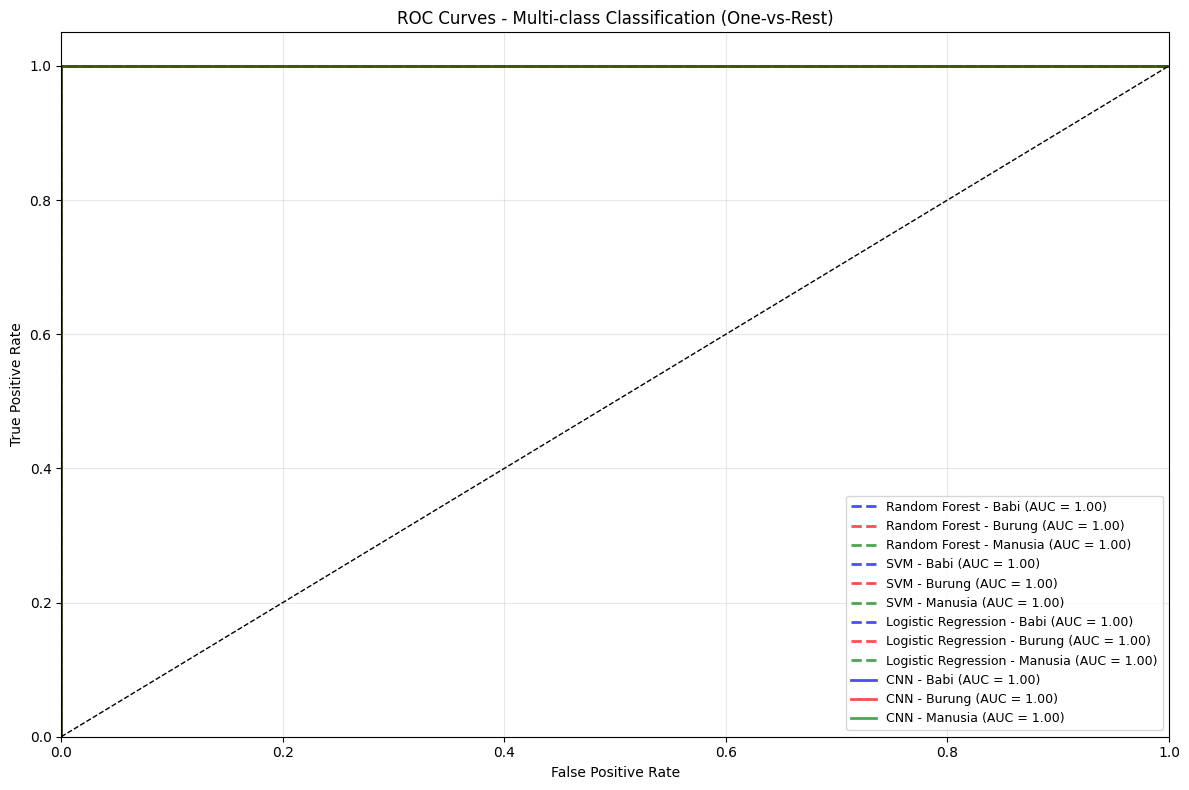

✅ ROC curves generated.


In [40]:
print("\n" + "="*50)
print("ROC CURVES (3 CLASSES - One-vs-Rest)")
print("="*50)

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels untuk ROC (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Dictionary untuk simpan model predictions
models_dict = {
    'Random Forest': rf_model,
    'SVM': svm_model,
    'Logistic Regression': logreg_model
}

# Warna untuk tiap kelas
colors = ['blue', 'red', 'green']
class_names = ['Babi', 'Burung', 'Manusia']

plt.figure(figsize=(12, 8))

# Untuk tiap model tradisional
for model_name, model in models_dict.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_tfidf)
    else:  # Untuk SVM dengan probability=True
        y_score = model.predict_proba(X_test_tfidf)

    # Hitung ROC untuk tiap kelas (one-vs-rest)
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=colors[i], linestyle='--',
                label=f'{model_name} - {class_names[i]} (AUC = {roc_auc:.2f})',
                alpha=0.7, linewidth=2)

# Untuk CNN (special handling)
print("\nGenerating ROC for CNN...")
y_score_cnn = cnn_model.predict(X_test_cnn)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_cnn[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=colors[i], linestyle='-',
            label=f'CNN - {class_names[i]} (AUC = {roc_auc:.2f})',
            alpha=0.7, linewidth=2)

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Multi-class Classification (One-vs-Rest)')
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ ROC curves generated.")


ROC CURVES FOR MULTI-CLASS (3 CLASSES)

1. Random Forest ROC Curve:


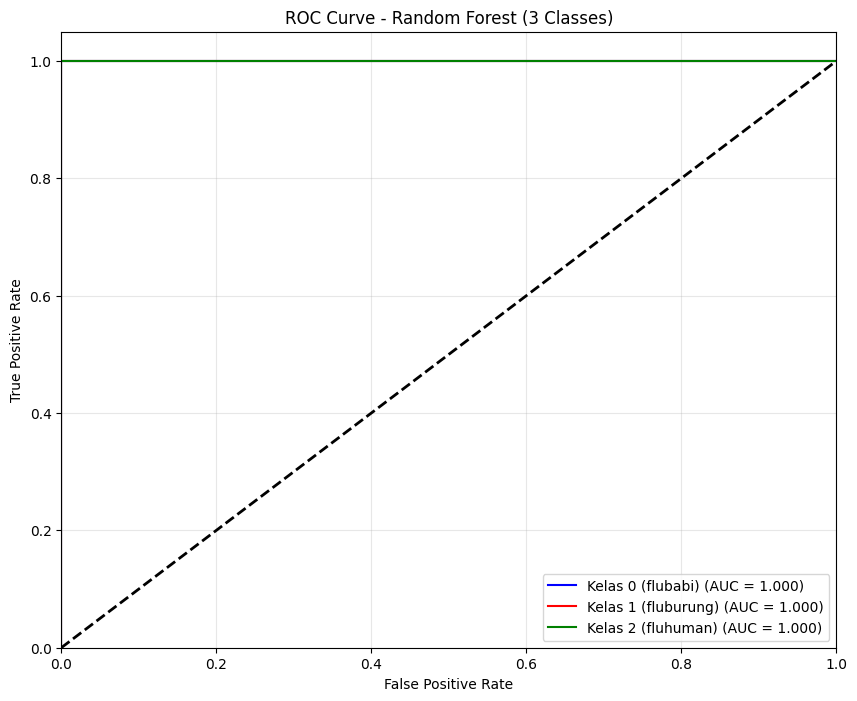


2. Logistic Regression ROC Curve:


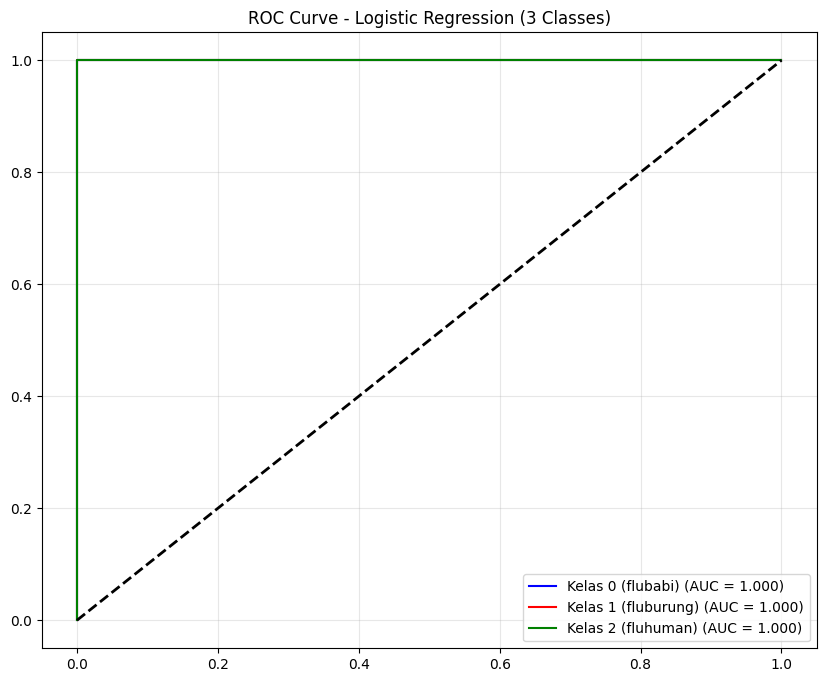


3. SVM ROC Curve:


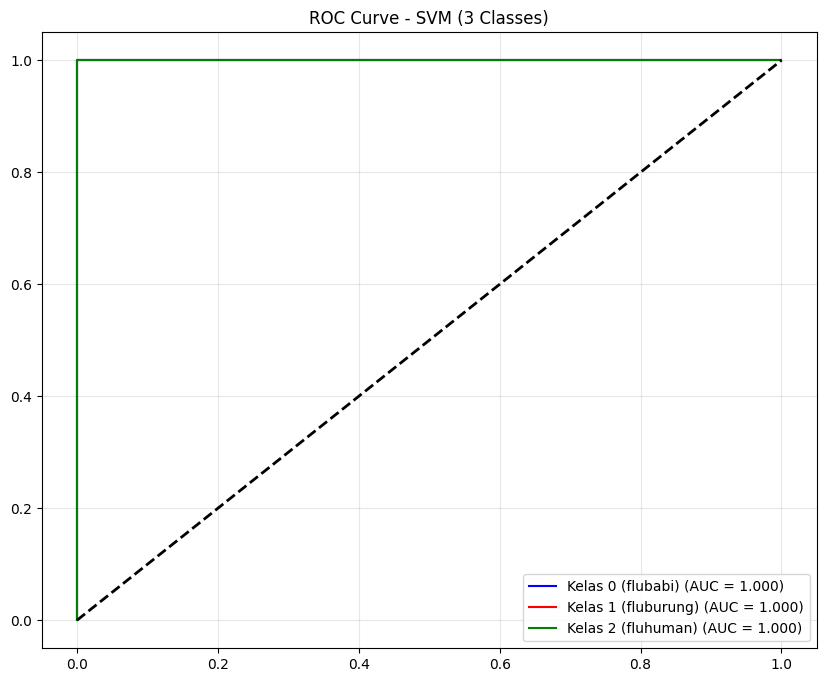


RECALL-PRECISION ANALYSIS PER CLASS

Performance Metrics per Class:
                  Model      Class  Precision  Recall  F1-Score  Support
0         Random Forest    flubabi   0.833333     1.0  0.909091       10
1         Random Forest  fluburung   1.000000     0.8  0.888889       10
2         Random Forest   fluhuman   1.000000     1.0  1.000000       10
3                   SVM    flubabi   1.000000     1.0  1.000000       10
4                   SVM  fluburung   1.000000     1.0  1.000000       10
5                   SVM   fluhuman   1.000000     1.0  1.000000       10
6   Logistic Regression    flubabi   1.000000     1.0  1.000000       10
7   Logistic Regression  fluburung   1.000000     1.0  1.000000       10
8   Logistic Regression   fluhuman   1.000000     1.0  1.000000       10
9                   CNN    flubabi   1.000000     1.0  1.000000       10
10                  CNN  fluburung   1.000000     1.0  1.000000       10
11                  CNN   fluhuman   1.000000     1.0  

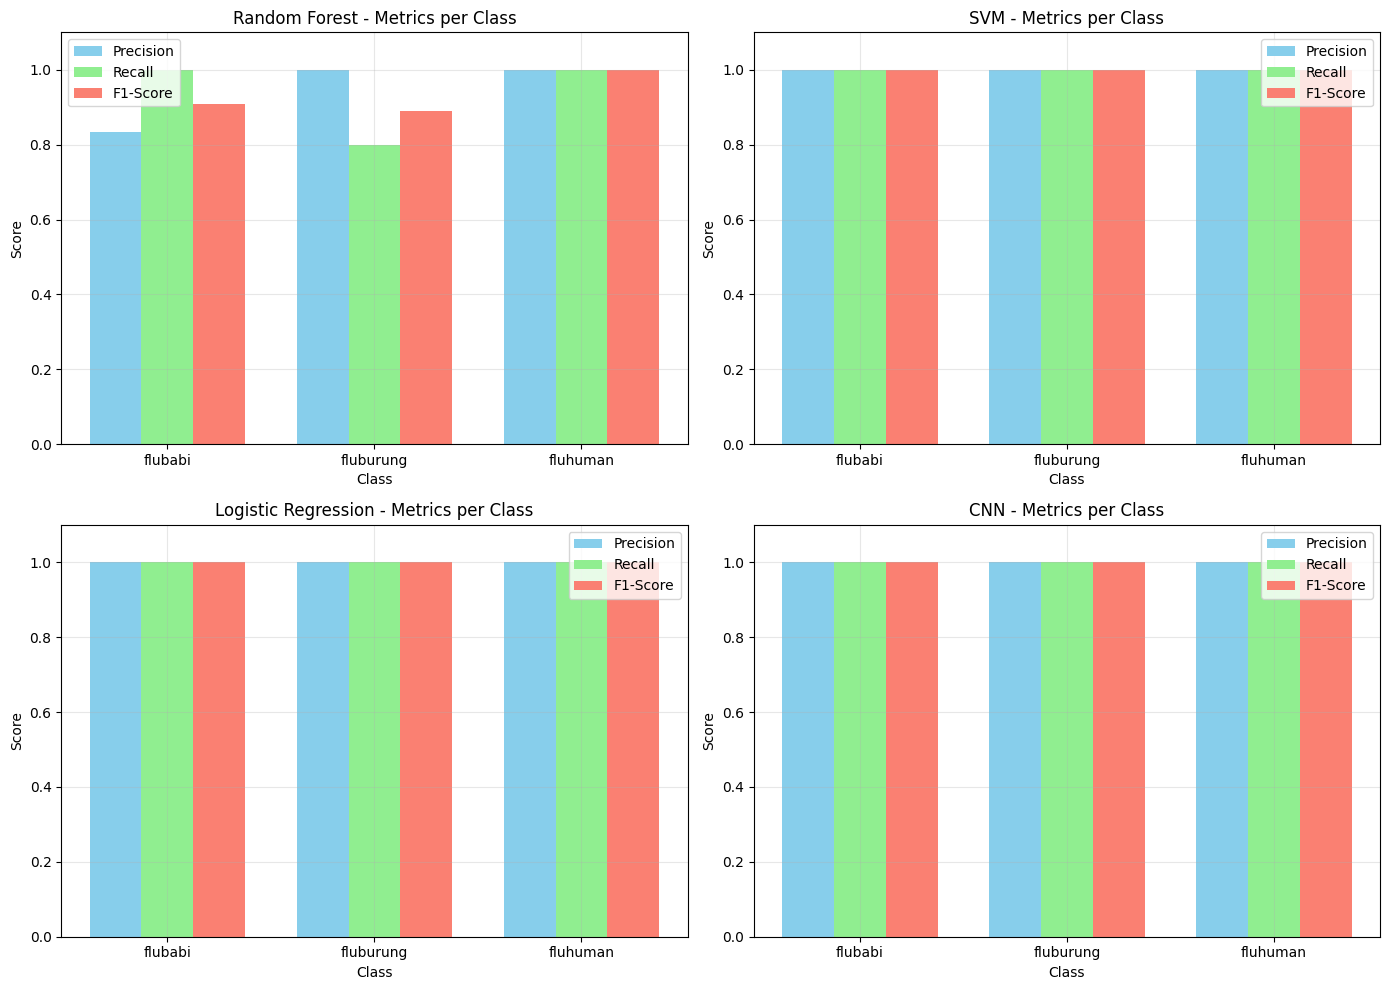


HIERARCHICAL CLUSTERING DENDROGRAM
Computing hierarchical clustering...


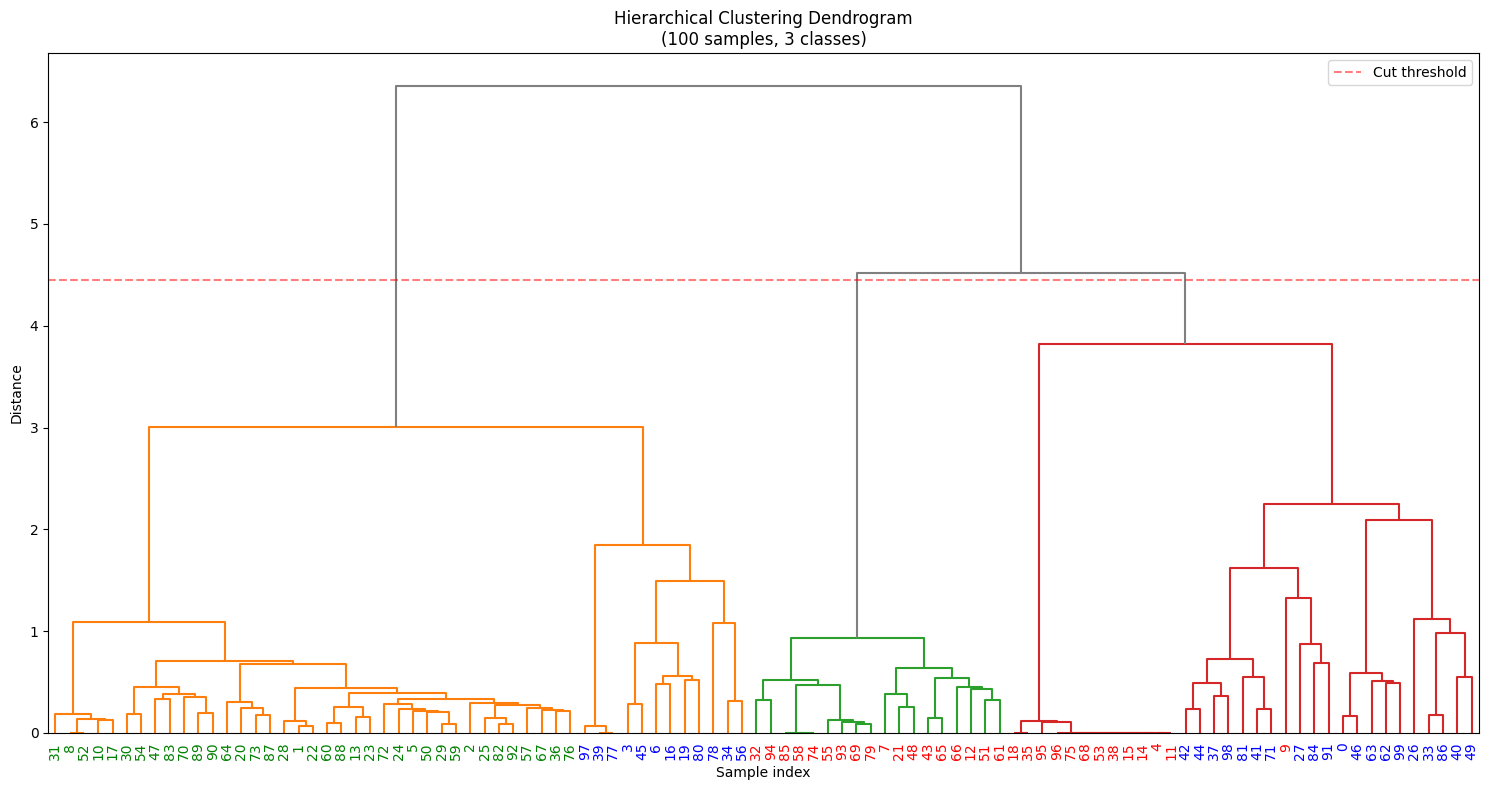


Interpretasi Dendrogram:
• Tinggi vertikal = distance/dissimilarity antar cluster
• Garis horizontal merah = threshold untuk membentuk 3 cluster
• Warna label: Biru=Babi, Merah=Burung, Hijau=Manusia
• Cluster yang baik: samples dengan label sama terkumpul bersama

SUMMARY ROC AUC SCORES (3 CLASSES)
                 Model  Class 0 (Babi) AUC  Class 1 (Burung) AUC  Class 2 (Manusia) AUC  Macro Avg AUC
0        Random Forest                 1.0                   1.0                    1.0            1.0
1  Logistic Regression                 1.0                   1.0                    1.0            1.0
2                  SVM                 1.0                   1.0                    1.0            1.0

ANALYSIS COMPLETE!


In [39]:
# ====================
# ROC CURVE (Multi-class)
# ====================

print("\n" + "="*50)
print("ROC CURVES FOR MULTI-CLASS (3 CLASSES)")
print("="*50)

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels untuk ROC multi-class
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = 3

# Warna untuk setiap kelas
colors = ['blue', 'red', 'green']

# Dictionary untuk menyimpan ROC AUC tiap model
roc_data = {}

# 1. RANDOM FOREST ROC
print("\n1. Random Forest ROC Curve:")
y_pred_rf_proba = rf_model.predict_proba(X_test_tfidf)
fpr_rf = {}
tpr_rf = {}
roc_auc_rf = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_bin[:, i], y_pred_rf_proba[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])
    plt.plot(fpr_rf[i], tpr_rf[i], color=colors[i],
             label=f'Kelas {i} ({labels[i]}) (AUC = {roc_auc_rf[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (3 Classes)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

roc_data['Random Forest'] = roc_auc_rf

# 2. LOGISTIC REGRESSION ROC
print("\n2. Logistic Regression ROC Curve:")
y_pred_logreg_proba = logreg_model.predict_proba(X_test_tfidf)
fpr_lr = {}
tpr_lr = {}
roc_auc_lr = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr_lr[i], tpr_lr[i], _ = roc_curve(y_test_bin[:, i], y_pred_logreg_proba[:, i])
    roc_auc_lr[i] = auc(fpr_lr[i], tpr_lr[i])
    plt.plot(fpr_lr[i], tpr_lr[i], color=colors[i],
             label=f'Kelas {i} ({labels[i]}) (AUC = {roc_auc_lr[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('ROC Curve - Logistic Regression (3 Classes)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

roc_data['Logistic Regression'] = roc_auc_lr

# 3. SVM ROC (jika probability=True)
print("\n3. SVM ROC Curve:")
if hasattr(svm_model, "predict_proba"):
    y_pred_svm_proba = svm_model.predict_proba(X_test_tfidf)
    fpr_svm = {}
    tpr_svm = {}
    roc_auc_svm = {}

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr_svm[i], tpr_svm[i], _ = roc_curve(y_test_bin[:, i], y_pred_svm_proba[:, i])
        roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])
        plt.plot(fpr_svm[i], tpr_svm[i], color=colors[i],
                 label=f'Kelas {i} ({labels[i]}) (AUC = {roc_auc_svm[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.title('ROC Curve - SVM (3 Classes)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

    roc_data['SVM'] = roc_auc_svm
else:
    print("SVM tidak memiliki probability estimates (probability=False)")

# ====================
# RECALL-PRECISION ANALYSIS
# ====================

print("\n" + "="*50)
print("RECALL-PRECISION ANALYSIS PER CLASS")
print("="*50)

from sklearn.metrics import precision_recall_fscore_support

models = {
    'Random Forest': y_pred_rf_test,
    'SVM': y_pred_svm_test,
    'Logistic Regression': y_pred_logreg_test,
    'CNN': y_pred_cnn  # dari CNN yang sudah diperbaiki
}

# DataFrame untuk menyimpan metrik per kelas
metrics_df = pd.DataFrame()

for model_name, y_pred in models.items():
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, average=None, labels=[0, 1, 2]
    )

    for i in range(n_classes):
        metrics_df = pd.concat([metrics_df, pd.DataFrame({
            'Model': [model_name],
            'Class': [labels[i]],
            'Precision': [precision[i]],
            'Recall': [recall[i]],
            'F1-Score': [f1[i]],
            'Support': [support[i]]
        })], ignore_index=True)

# Tampilkan metrik
print("\nPerformance Metrics per Class:")
print(metrics_df.to_string())

# Visualisasi Recall-Precision per model
plt.figure(figsize=(14, 10))

# Plot untuk setiap model
for idx, model_name in enumerate(models.keys(), 1):
    plt.subplot(2, 2, idx)

    model_data = metrics_df[metrics_df['Model'] == model_name]

    x = np.arange(len(labels))
    width = 0.25

    plt.bar(x - width, model_data['Precision'], width, label='Precision', color='skyblue')
    plt.bar(x, model_data['Recall'], width, label='Recall', color='lightgreen')
    plt.bar(x + width, model_data['F1-Score'], width, label='F1-Score', color='salmon')

    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title(f'{model_name} - Metrics per Class')
    plt.xticks(x, labels)
    plt.ylim([0, 1.1])
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ====================
# DENDROGRAM (Hierarchical Clustering)
# ====================

print("\n" + "="*50)
print("HIERARCHICAL CLUSTERING DENDROGRAM")
print("="*50)

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Gunakan subset data untuk visualisasi yang lebih jelas
n_samples = min(100, len(X_train_dense))
sample_indices = np.random.choice(len(X_train_dense), n_samples, replace=False)
X_sample = X_train_dense[sample_indices]
y_sample = y_train.iloc[sample_indices]

# Hitung linkage matrix
print("Computing hierarchical clustering...")
Z = linkage(X_sample, method='ward', metric='euclidean')

# Plot dendrogram
plt.figure(figsize=(15, 8))
plt.title(f'Hierarchical Clustering Dendrogram\n({n_samples} samples, 3 classes)')
plt.xlabel('Sample index')
plt.ylabel('Distance')

# Buat dendrogram dengan warna berdasarkan kelas
dendrogram(
    Z,
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=0.7 * max(Z[:, 2]),
    above_threshold_color='grey'
)

# Tambah warna untuk label asli
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    idx = int(lbl.get_text())
    if idx < len(y_sample):
        true_label = y_sample.iloc[idx]
        color_map = {0: 'blue', 1: 'red', 2: 'green'}
        lbl.set_color(color_map.get(true_label, 'black'))

plt.axhline(y=0.7 * max(Z[:, 2]), color='r', linestyle='--', alpha=0.5, label='Cut threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Interpretasi clustering
print("\nInterpretasi Dendrogram:")
print("• Tinggi vertikal = distance/dissimilarity antar cluster")
print("• Garis horizontal merah = threshold untuk membentuk 3 cluster")
print("• Warna label: Biru=Babi, Merah=Burung, Hijau=Manusia")
print("• Cluster yang baik: samples dengan label sama terkumpul bersama")

# ====================
# SUMMARY ROC AUC
# ====================

print("\n" + "="*50)
print("SUMMARY ROC AUC SCORES (3 CLASSES)")
print("="*50)

# Tabel summary ROC AUC
roc_summary = pd.DataFrame()
for model_name, auc_scores in roc_data.items():
    roc_summary = pd.concat([roc_summary, pd.DataFrame({
        'Model': [model_name],
        'Class 0 (Babi) AUC': [auc_scores.get(0, np.nan)],
        'Class 1 (Burung) AUC': [auc_scores.get(1, np.nan)],
        'Class 2 (Manusia) AUC': [auc_scores.get(2, np.nan)],
        'Macro Avg AUC': [np.mean(list(auc_scores.values())) if auc_scores else np.nan]
    })], ignore_index=True)

print(roc_summary.to_string())

print("\n" + "="*50)
print("ANALYSIS COMPLETE!")
print("="*50)